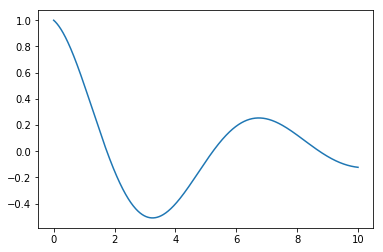

In [46]:
# Reference: https://hal.inria.fr/inria-00179732/document

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
%matplotlib inline

# set up a sum of coefficients to estimate

N = 1
T = 10
alpha_real = [-0.2]
alpha_imag = [0.9]
times = np.linspace(0, T, 1000)
signal = sum([np.exp((alpha_real[i] + 1j * alpha_imag[i]) * times) for i in range(N)])
plt.plot(times, signal.real)

In [50]:
# set up the matrix equation

fact = np.math.factorial

A = np.zeros((N, N), dtype='complex')
d = np.zeros(N, dtype='complex')

def permute(n, k):
    # useful because it's the coefficient on the 'k'th derivative of s^n
    if n < k:
        print("permute got a bad value")
        return 0
    return fact(n)/fact(n - k)

def choose(n, k):
    # useful because product rule works wow
    if n < k:
        print("choose got a bad value")
        return 0
    return fact(n)/(fact(k)*fact(n - k))

# set up d

for i in range(1,N+1):
    for p in range(1,N+1):
        to_int_d = (T - times)**i * times**(N+i-p) * signal
        int_d = integrate.simps(to_int_d, times)
        d[i - 1] += choose(N + i, p) * permute(N + 1, p) * (-1)**(N + i - p)/fact(i) * int_d

# set up A
for i in range(1,N+1):
    for j in range(1,N+1):
        for p in range(1,N+1-j):
            to_int_a = (T - times)**(j+p) * times**(N+i-p) * signal
            int_a = integrate.simps(to_int_a, times)
            A[i-1][j-1] = choose(N+i, p) * permute(N+1-j, p) * (-1)**(N+i-p)/fact(j+p) * int_a

# d = A*theta
theta = np.linalg.inv(A).dot(d)
theta = np.append(theta, 1)
alpha = np.roots(theta)
print(alpha)

reconstructed = sum([np.exp(alpha[i] * times) for i in range(N)])

plt.plot(times, signal.real, label='True')
plt.plot(times, reconstructed.real, label='Reconstructed')
plt.legend()

LinAlgError: Singular matrix